<a href="https://colab.research.google.com/github/rimaakhmedov/toxicity-analysis-nlp/blob/main/toxicity_analysis_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Установка и импорт библиотек

In [1]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
!pip install pymorphy3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 20.3 MB/s eta 0:00:00


In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00


In [4]:
!pip install accelerate -U

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import nltk
import pymorphy3
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from wordcloud import WordCloud


from datasets import load_dataset
from datasets import Dataset as ds

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForPreTraining, AutoModelForSequenceClassification
from transformers import AdamW
from transformers import TrainingArguments, Trainer
from transformers import get_scheduler
from transformers import DataCollatorWithPadding
from datasets import load_metric


from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

In [6]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Загрузка датасета и его обзор

In [7]:
train_dataset = load_dataset("d0rj/rudetoxifier_data", split="train")
test_dataset = load_dataset("d0rj/rudetoxifier_data", split="test")

Generating train split:   0%|          | 0/163187 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [8]:
train = train_dataset.to_pandas()
test = test_dataset.to_pandas()

In [9]:
print(train.shape)
print(test.shape)

(163187, 2)
(10000, 2)


In [10]:
train.head(5)

,text,toxic
0,дворника надо тоже уничтожить!,1.0
1,"моя старшая неделю шипела, не принимала подкид...",0.0
2,полностью с вами согласна!,0.0
3,"хоть ногу вверх, ничего не изменится",0.0
4,а что значит - левого ребенка?,0.0


In [11]:
test.head(5)

,text,toxic
0,долбоебы не иначе,1.0
1,Вечная память героям! Вас будут помнить и чере...,1.0
2,выебать его и его ночяльника и кинуть его жопу...,1.0
3,такую надо ебать,1.0
4,долбоеб старый в хоч импо тент но полиз понюх ...,1.0


In [12]:
train.dtypes

text      object
toxic    float64
dtype: object

In [13]:
train['toxic'] = train['toxic'].astype(int)
train['toxic'] = train['toxic'].astype(int)

##EDA

###Облако слов

In [14]:
stop_words = stopwords.words("russian")

def plot_wordcloud(comment, title):
    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=stop_words,
                          min_font_size=10).generate(comment)
    plt.figure(figsize=(14, 6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title, fontdict={'fontsize': 20})
    plt.show()

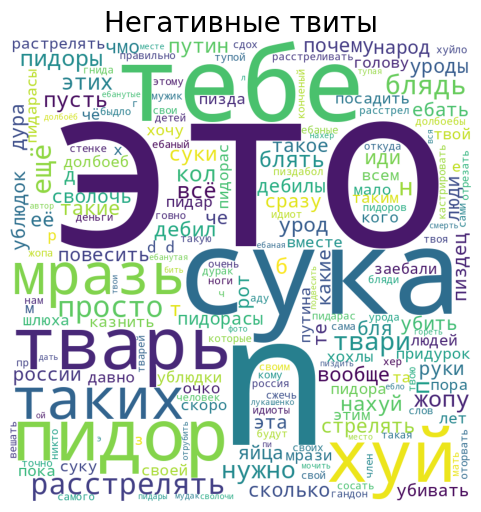

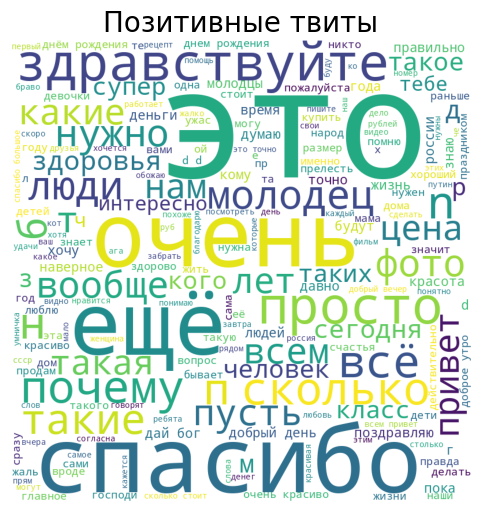

In [15]:
negative_tweets = train['text'][train['toxic'] == 1].to_string()
positive_tweets = train['text'][train['toxic'] == 0].to_string()

plot_wordcloud(negative_tweets, 'Негативные твиты')
plot_wordcloud(positive_tweets, 'Позитивные твиты')

###Изучим данные

In [16]:
train_eda = train.copy()
train_eda['comment_length'] = train_eda['text'].str.len()
train_eda['num_voskl'] = train_eda['text'].str.count('!')
train_eda['num_vopros'] = train_eda['text'].str.count('\?')
train_eda['num_punctuations'] = train_eda['text'].str.count('[.,:;]')
train_eda['num_words'] = train_eda['text'].apply(lambda x: len(x.split()))
train_eda.head()

,text,toxic,comment_length,num_voskl,num_vopros,num_punctuations,num_words
0,дворника надо тоже уничтожить!,1,30,1,0,0,4
1,"моя старшая неделю шипела, не принимала подкид...",0,195,0,0,8,28
2,полностью с вами согласна!,0,26,1,0,0,4
3,"хоть ногу вверх, ничего не изменится",0,36,0,0,1,6
4,а что значит - левого ребенка?,0,30,0,1,0,6


In [17]:
train_eda['num_words'].max()

1078

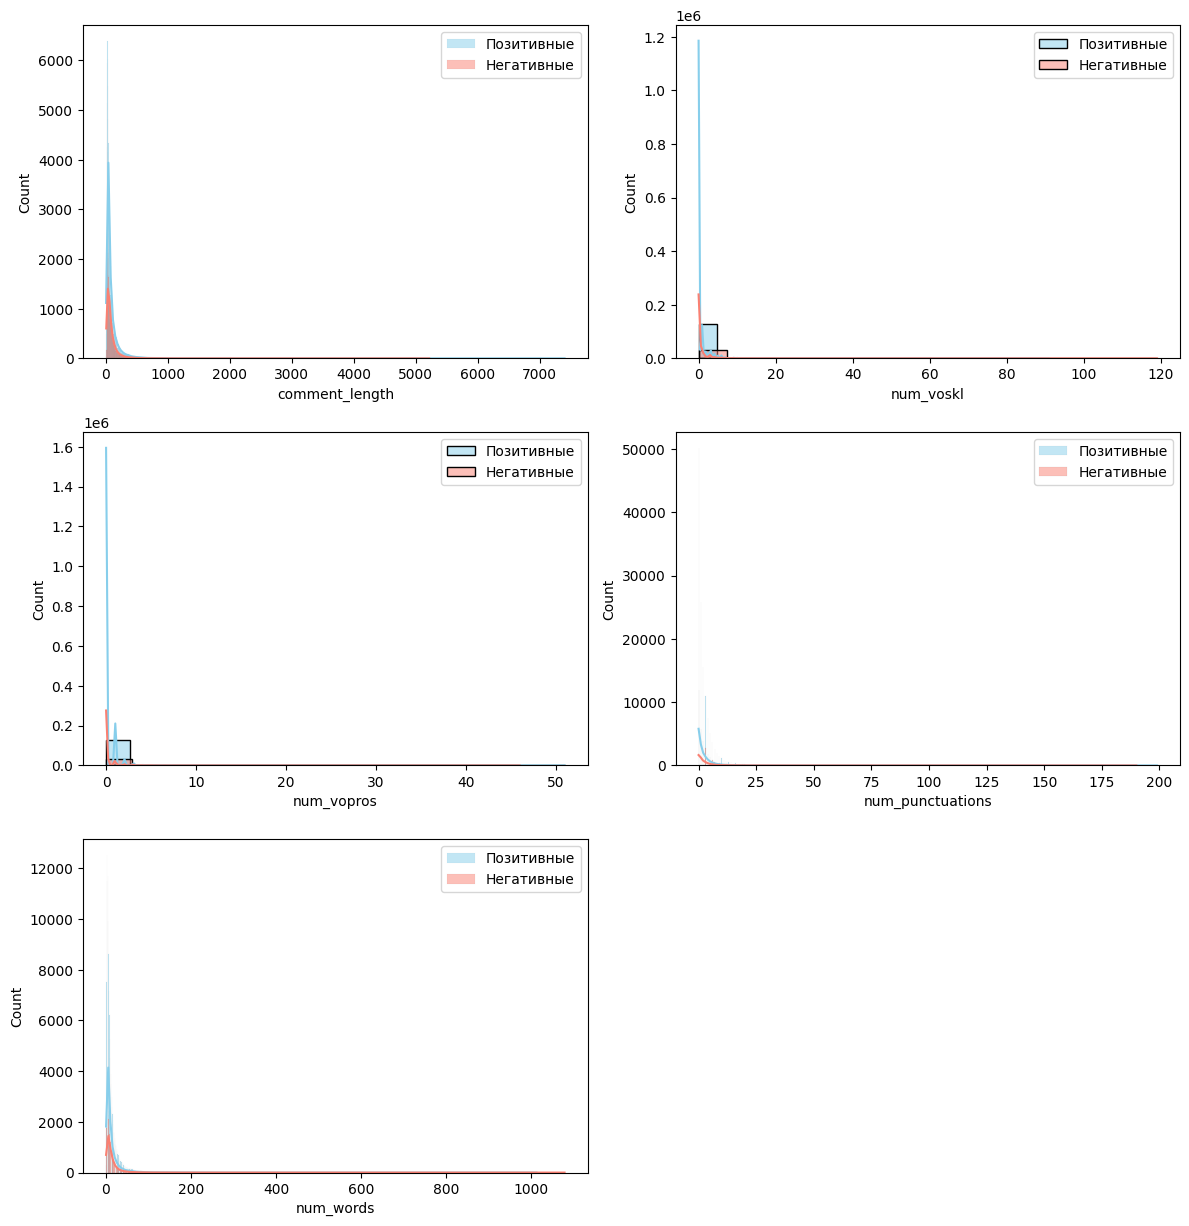

In [18]:
# График взаимосвязи наших функций с настроениями
features = ['comment_length', 'num_voskl', 'num_vopros',
            'num_punctuations', 'num_words']

if set(features).issubset(train_eda.columns):
    plt.figure(figsize=(12, 16))
    colors = ['skyblue', 'salmon']

    for i, feature in enumerate(features, 1):
        plt.subplot(4, 2, i)
        sns.histplot(train_eda[train_eda.toxic == 0][feature], label='Позитивные', kde=True, color=colors[0])
        sns.histplot(train_eda[train_eda.toxic == 1][feature], label='Негативные', kde=True, color=colors[1])
        plt.legend()

    plt.tight_layout()
    plt.show()

## Предобработка

In [19]:
train_copy = train.copy()
test_copy = test.copy()

In [20]:
morph = pymorphy3.MorphAnalyzer()

In [21]:
def preprocess_text(text):
    pattern = re.compile(r'[a-zA-Zа-яА-Я]+', re.UNICODE)
    words = re.findall(pattern, text)

    words = word_tokenize(' '.join(words), language='russian')
    filtered_words = [word for word in words if word.lower() not in stop_words]

    lemmatized_words = [morph.parse(word)[0].normal_form for word in filtered_words]

    return ' '.join(lemmatized_words)

In [22]:
train_copy['text'] = train_copy['text'].apply(preprocess_text)

In [23]:
train_copy.head(15)

,text,toxic
0,дворник уничтожить,1
1,старший неделя шипеть принимать подкидыш котор...,0
2,полностью вы согласный,0
3,нога вверх измениться,0
4,значит левый ребёнок,0
5,вечер добрый постарелый,0
6,порода,0
7,спасатель просто петух чванливый взять наш пац...,1
8,замечательный юбилей голос чудо заслушаться чт...,0
9,красавец,0


In [24]:
test_copy['text'] = test_copy['text'].apply(preprocess_text)

In [25]:
train_data, val_data = train_test_split(train_copy, test_size=0.10, random_state=42)

In [26]:
print(train_data.shape)
print(val_data.shape)

(146868, 2)
(16319, 2)


In [27]:
train_dataset = ds.from_pandas(train_data)
val_dataset = ds.from_pandas(val_data)
test_dataset = ds.from_pandas(test_copy)

In [28]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset({
    features: ['text', 'toxic', '__index_level_0__'],
    num_rows: 146868
})
Dataset({
    features: ['text', 'toxic', '__index_level_0__'],
    num_rows: 16319
})
Dataset({
    features: ['text', 'toxic'],
    num_rows: 10000
})


## Работа с Hugging Face и PyTorch

In [29]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [30]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [31]:
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/146868 [00:00<?, ? examples/s]

Map:   0%|          | 0/16319 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [32]:
tokenized_train

Dataset({
    features: ['text', 'toxic', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 146868
})

In [33]:
tokenized_train = tokenized_train.remove_columns(["text", "__index_level_0__"])
tokenized_val = tokenized_val.remove_columns(["text", "__index_level_0__"])
tokenized_test = tokenized_test.remove_columns(["text"])

In [34]:
tokenized_train = tokenized_train.rename_column("toxic", "labels")
tokenized_test = tokenized_test.rename_column("toxic", "labels")

In [35]:
tokenized_val = tokenized_val.rename_column("toxic", "labels")

In [36]:
tokenized_train

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 146868
})

In [37]:
tokenized_val

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 16319
})

In [38]:
tokenized_train.set_format("torch")
tokenized_test.set_format("torch")

In [39]:
tokenized_val.set_format("torch")

In [40]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [41]:
train_data = DataLoader(tokenized_train,
                        shuffle=True,
                        batch_size=8,
                        collate_fn=data_collator
                                        )
val_data = DataLoader(tokenized_val,
                      batch_size=8,
                      collate_fn=data_collator
                                      )
test_data = DataLoader(tokenized_test,
                        batch_size=8,
                        collate_fn=data_collator
                                       )

In [42]:
for batch in train_data:
    [print('{:>20} : {}'.format(k,v.shape)) for k,v in batch.items()]
    break

              labels : torch.Size([8])
           input_ids : torch.Size([8, 120])
      token_type_ids : torch.Size([8, 120])
      attention_mask : torch.Size([8, 120])


In [43]:
device = "cuda"

In [44]:
model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny", num_labels = 2)

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.7232, grad_fn=<NllLossBackward0>) torch.Size([8, 2])


In [46]:
BATCH_SIZE = 8
EPOCHS = 3
lr = 3e-5

In [47]:
NUM_TRAINING_STEPS = EPOCHS * len(train_data)
print(NUM_TRAINING_STEPS)

optimizer = AdamW(model.parameters(), lr=lr)
lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=NUM_TRAINING_STEPS
                            )

55077


In [48]:
model.to(device)
device

'cuda'

In [49]:
progress_bar = tqdm(range(NUM_TRAINING_STEPS))

model.train()
for epoch in range(EPOCHS):
    for batch in train_data:
        batch = {k:v.to(device) for k,v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/55077 [00:00<?, ?it/s]

In [50]:
metric = load_metric("accuracy")
model.eval()
for batch in val_data:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.9580856670139102}

In [51]:
toxic_com_1 = "Вечная память героям! Вас будут помнить и через 100 лет, а плешивого педофила - разве что по карикатурам"
toxic_com_2 = "Слишком женоподобное лицо. Настоящие солдаты уже закончились, наверное."

In [52]:
tokenized = tokenizer(toxic_com_1, return_tensors="pt")
tokenized

{'input_ids': tensor([[    2,   282, 14632,  1545, 16466, 18800,   656,     5,   282,  4992,
         16312, 26662, 18853,   320,  2277,   793,  2262,    16,   312,   327,
          1736, 14571,  2095,   327, 10138,   721,  8243,   971,    17,  4495,
          3003,  1046,   705,  8573,  3544, 10903,   656,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [53]:
def preprocess_and_predict(text: str, device, model):
  preprocessed = preprocess_text(text)
  tokenized = tokenizer(preprocessed, return_tensors="pt")

  model.to(device)
  tokenized.to(device)

  with torch.no_grad():
    outputs = model(**tokenized)

  predictions = torch.softmax(outputs.logits, dim=1).tolist()[0]

  # Вывод результата
  print("Class probabilities:", predictions)

In [54]:
preprocess_and_predict(toxic_com_1, device, model)

Class probabilities: [0.09436196833848953, 0.9056380391120911]


In [55]:
preprocess_and_predict(toxic_com_2, device, model)

Class probabilities: [0.9845101237297058, 0.01548989862203598]


In [59]:
torch.save(model, '/content/drive/MyDrive/fine-tuned models/ta-model')